In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from dln_dA import dA
import numpy as np
from matplotlib import pyplot as plt
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
import timeit

In [11]:
def make_simple_data(w, h, aw, ah):
    values = np.random.uniform(0.0, 1.0, (ah, aw))
    result = np.zeros((w, h, 3))
    for i in range(ah):
        for j in range(aw):
            result[i*(h/ah):(i+1)*(h/ah), 
                   j*(w/aw):(j+1)*(w/aw)] = values[i, j]
    return result

def make_simple_dataset(w, h, aw, ah, n):
    return np.asarray([make_simple_data(w, h, aw, ah) for i in range(n)], dtype=theano.config.floatX)

In [12]:
n_training_examples = 1000


w = 60
h = 60
aw = 3
ah = 2
training_data = make_simple_dataset(w, h, aw, ah, n_training_examples)
training_data_flat = training_data.reshape((n_training_examples, w*h, 3))
training_data_flat_nocl = np.mean(training_data_flat, axis=2)

# print training_data
# print '--------'
# print training_data_flat
# print '--------'
# print training_data_flat_nocl

train_set_x = theano.shared(training_data_flat_nocl, name='train', borrow=True)

In [13]:
learning_rate = 10
batch_size = 10
training_epochs = 1000
n_train_batches = n_training_examples/batch_size

hidden_units=aw*ah

In [14]:
# allocate symbolic variables for the data
index = T.lscalar()    # index to a [mini]batch
x = T.matrix('x')  # the data is presented as rasterized images

rng = np.random.RandomState(123)
theano_rng = RandomStreams(rng.randint(2 ** 30))

da = dA(
    numpy_rng=rng,
    theano_rng=theano_rng,
    input=x,
    n_visible=h*w,
    n_hidden=hidden_units
)

cost, updates = da.get_cost_updates(
    corruption_level=0.0,
    learning_rate=learning_rate
)

train_da = theano.function(
    [index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size]
    }
)


In [19]:
start_time = timeit.default_timer()

############
# TRAINING #
############

# go through training epochs
for epoch in xrange(training_epochs):
    # go through trainng set
    c = []
    for batch_index in xrange(n_train_batches):
        c.append(train_da(batch_index))

    if epoch == 0 or (epoch+1) % 10 == 0:
        print 'Training epoch %d, cost ' % epoch, np.mean(c)

end_time = timeit.default_timer()

training_time = (end_time - start_time)

print 'The code ran for %.2fm' % (training_time / 60.)

Training epoch 0, cost  0.0237178664954
Training epoch 9, cost  0.0233875206723
Training epoch 19, cost  0.0236041817629
Training epoch 29, cost  0.023154544709
Training epoch 39, cost  0.0230297159032
Training epoch 49, cost  0.0228733745674
Training epoch 59, cost  0.0233443821382
Training epoch 69, cost  0.0226870063157
Training epoch 79, cost  0.0227045802331
Training epoch 89, cost  0.0225950177884
Training epoch 99, cost  0.0226076694951
Training epoch 109, cost  0.0224557237241
Training epoch 119, cost  0.0226844181496
Training epoch 129, cost  0.022135404636
Training epoch 139, cost  0.0223806293276
Training epoch 149, cost  0.0224702362914
Training epoch 159, cost  0.0224602841626
Training epoch 169, cost  0.0219957221954
Training epoch 179, cost  0.0220480877455
Training epoch 189, cost  0.0219698000461
Training epoch 199, cost  0.0215775126529
Training epoch 209, cost  0.0216706909918
Training epoch 219, cost  0.0219177230036
Training epoch 229, cost  0.0217103664314
Trainin

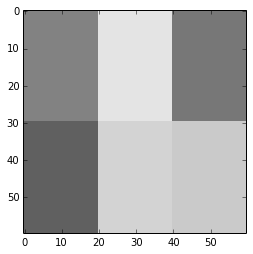

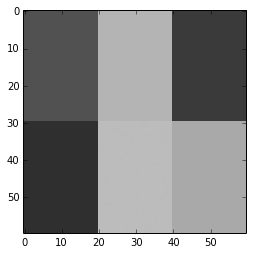

In [20]:
def make_rgb_from_val(data, w, h):
    return np.repeat(batch[index].reshape(h, w), 3).reshape(h, w, 3)

batch = training_data_flat_nocl[0:batch_size]
index = 4

example_img = np.repeat(batch[index].reshape(h, w), 3).reshape(h, w, 3)
plt.imshow(example_img, interpolation='nearest')
plt.show()

enc = da.get_reconstructed_input(da.get_hidden_values(da.x))

reconstr_batch = enc.eval({da.x: batch})

example_recon = np.repeat(reconstr_batch[index].reshape(h, w), 3).reshape(h, w, 3)
plt.imshow(example_recon, interpolation='nearest')
plt.show()
